# CS 482: Environmental Navigation Project v.2

In class we talked about the properties of light. One of the topics we discussed was how we could compute the scene lighting of a Lambertian object from its normals and its albedo (and assuming we know where the light is). This process is relatively "simple" once you understand what's going on. For a Lambertian object, the amount of light collected by a light source is proportional to the cosine of the angle between the surface and the light source. So, for every point on the surface $\mathbf{x}$:

$$ \text{Observed Brightness}(\mathbf{x}) = \text{Albedo}(\mathbf{x})\cos(\theta_\mathbf{x}) = \text{Albedo}(\mathbf{x}) \left[ \hat{l} \cdot \hat{n}(\mathbf{x}) \right] $$

where $\hat{l}$ is the *light direction* (normalized) and $\hat{n}(\mathbf{x})$ is the *surface normal* at location $\mathbf{x}$.

For this breakout session, I have provided you with an *albedo matrix* `albedos` (of dimension $m \times n$) and the accompanying *normals* `normals` (of dimension $m \times n \times 3$, where the normal vector at coordinate `i, j` is `normals[i, j]`).

**TASK** Write a function `light_scene` that computes an $m \times n$ "lit scene" image from (1) the albedos, (2) the normals, and (3) the light directions.

I have provided you with both data and some partially-implemented functions for this process. If your `light_scene` function is implemented correctly, the `light_scene_interactive` function I have included below should instantiate an interactive widget with which you can move the light around with sliders and see the effect.

**PLOTS** Include 4 different lightings of the "bunny" scene in your writeup.

*Data and Images* from: 
- Buddah: https://courses.cs.washington.edu/courses/csep576/05wi/projects/project3/project3.htm
- Scholar: http://vision.seas.harvard.edu/qsfs/Data.html

In [17]:
# from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# checkpoint = "vinvino02/glpn-nyu"

# image_processor = AutoImageProcessor.from_pretrained(checkpoint)
# model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

### Step 0: Testing the Depth Estimator Pipeline

In [18]:
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")
output = depth_estimator("images/book.webp")

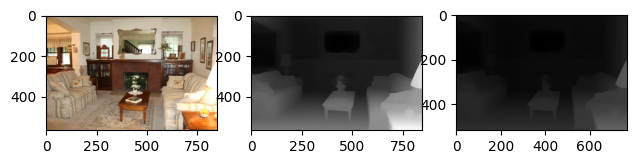

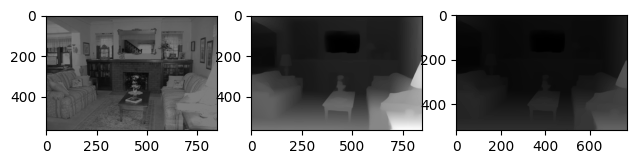

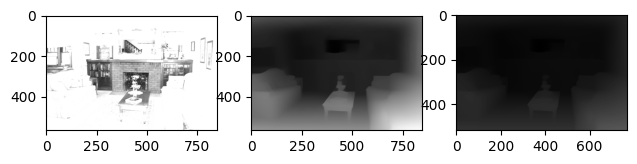

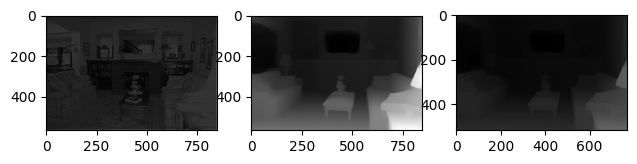

In [19]:
from PIL import Image
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

def display_depths(img, depth_estimator):
    plt.figure(figsize=(7.5, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img)

    depths = depth_estimator(img)
    plt.subplot(1, 3, 2)
    plt.imshow(depths["depth"], cmap='gray', vmin=0, vmax=255)

    plt.subplot(1, 3, 3)
    plt.imshow(depths["predicted_depth"][0], cmap='gray', vmin=0, vmax=255)


img = Image.open("images/room2.webp")
img_array = np.asarray(img)[:, :, 0]
low_contrast = np.zeros((3, 3))
low_contrast[1, 1] = 0.5
low_cont_img = Image.fromarray(scipy.signal.convolve2d(img_array, low_contrast, mode='same'))

high_contrast = np.zeros((3, 3))
high_contrast[1, 1] = 2
high_cont_img = Image.fromarray(scipy.signal.convolve2d(img_array, high_contrast, mode='same'))

sharpen = np.zeros((3, 3))
sharpen[1, 1] = 2
sharpen = sharpen - (1.0 / 5) * np.ones((3, 3))
sharp_img = Image.fromarray(scipy.signal.convolve2d(img_array, sharpen, mode='same'))



display_depths(img, depth_estimator)
display_depths(low_cont_img, depth_estimator)
display_depths(high_cont_img, depth_estimator)
display_depths(sharp_img, depth_estimator)



In [20]:
output = depth_estimator("http://images.cocodataset.org/val2017/000000039769.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["predicted_depth"].shape
output["predicted_depth"]

tensor([[[26.3996, 26.3003, 26.3928,  ..., 24.8489, 24.9059, 20.0686],
         [26.2259, 26.2092, 26.3427,  ..., 24.8448, 24.6682, 24.6084],
         [26.0719, 26.0483, 26.1254,  ..., 24.7053, 24.6746, 24.5809],
         ...,
         [43.2635, 43.2343, 43.2892,  ..., 39.0545, 39.2171, 39.0818],
         [43.3636, 43.2703, 43.3899,  ..., 39.1390, 38.9937, 39.0318],
         [38.7509, 43.2192, 43.4387,  ..., 38.5408, 38.3691, 35.3692]]])

In [21]:
print(output)

{'predicted_depth': tensor([[[26.3996, 26.3003, 26.3928,  ..., 24.8489, 24.9059, 20.0686],
         [26.2259, 26.2092, 26.3427,  ..., 24.8448, 24.6682, 24.6084],
         [26.0719, 26.0483, 26.1254,  ..., 24.7053, 24.6746, 24.5809],
         ...,
         [43.2635, 43.2343, 43.2892,  ..., 39.0545, 39.2171, 39.0818],
         [43.3636, 43.2703, 43.3899,  ..., 39.1390, 38.9937, 39.0318],
         [38.7509, 43.2192, 43.4387,  ..., 38.5408, 38.3691, 35.3692]]]), 'depth': <PIL.Image.Image image mode=L size=640x480 at 0x24425114A10>}


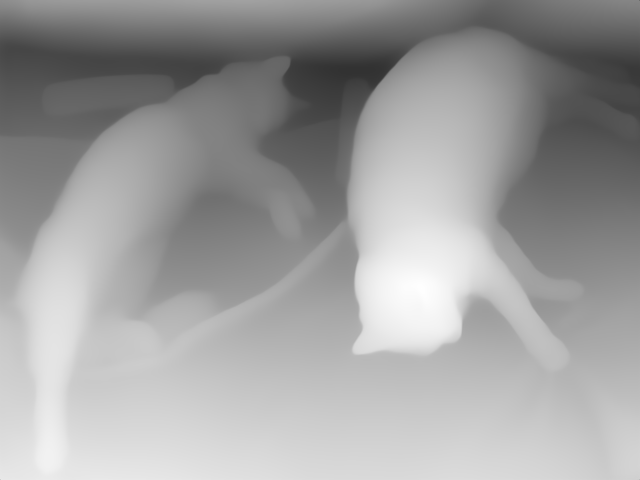

In [22]:
output["depth"]

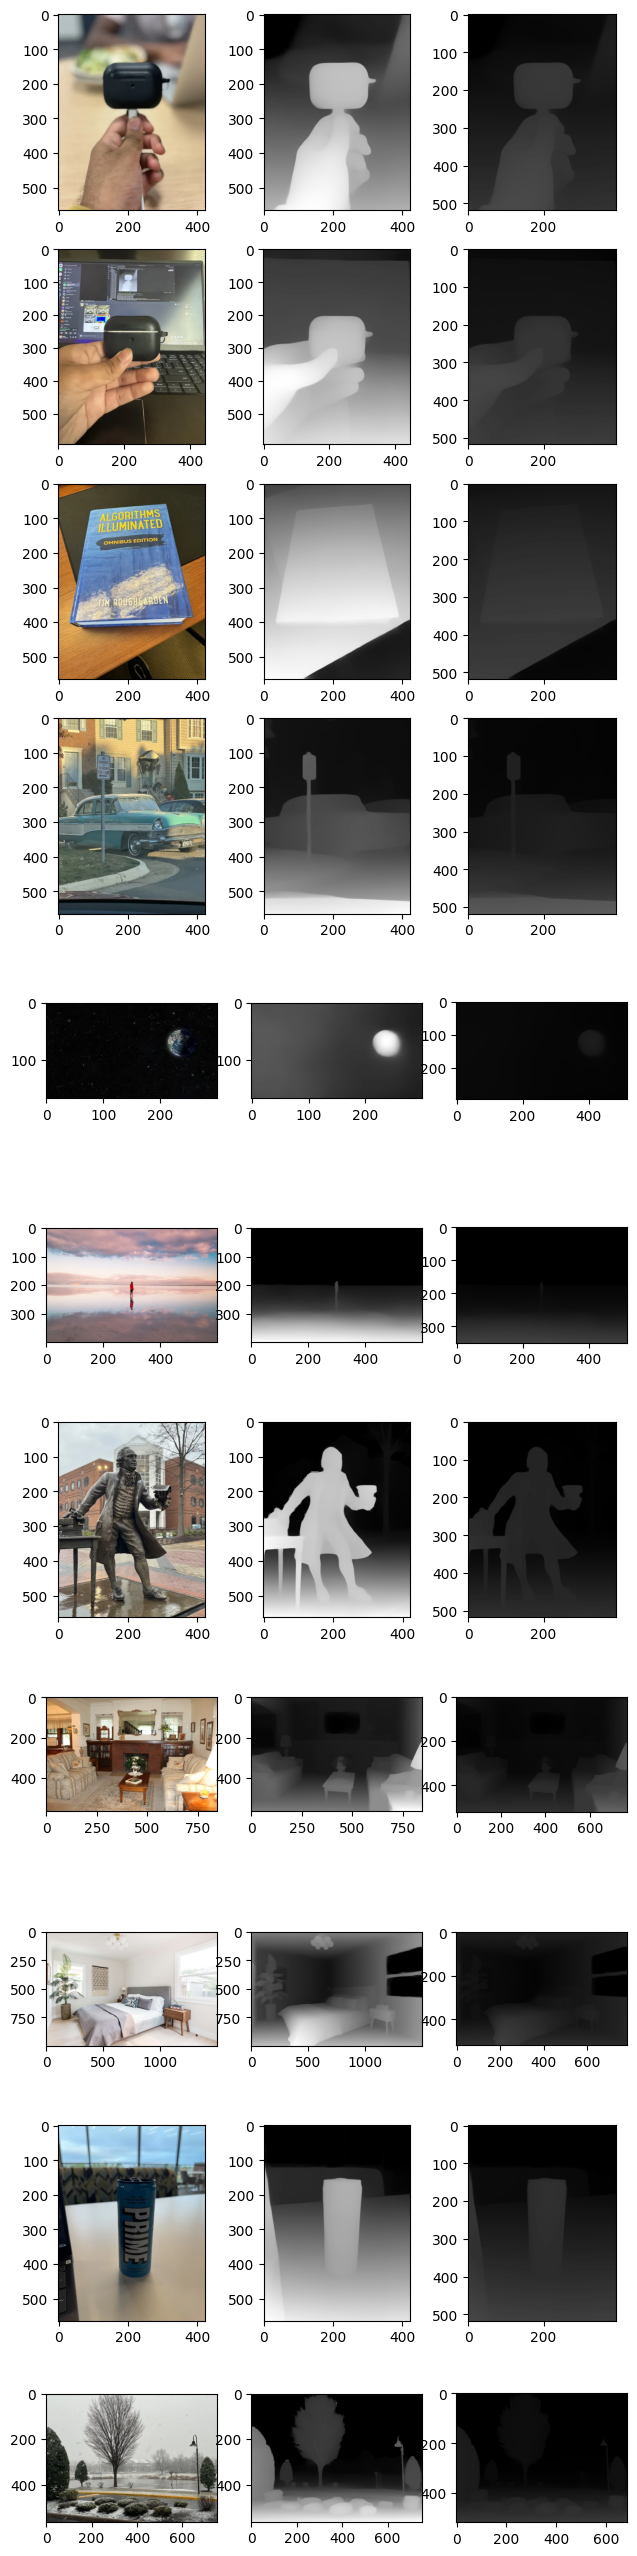

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
"""
Helper Function to display the images in a folder, their depth maps, and their predicted depths.
Displays the image inside of the function in a display_count x 3 grid and does not return any values.

Parameters
----------
depth_model: the pre-loaded depth estimator pipeline that will create the depth maps for the images

img_folder_path: the path (relative or absolute) to the image folder
    Note: do not include a final slash at the end

display_count: the number of images to be displayed
    If this argument is not given, this function will display all the images in the folder.

"""
def display_img_depths(depth_model, img_folder_path="images", display_count=None):
    if (depth_model is None):
        return
    
    grid_out = 0    # The image output after running the depth estimator
    orig_img = None # The original PIL Image  
    num_cols = 3    # The number of columns: original, depth, predicted_depth
    image_paths = os.listdir(img_folder_path)

    if (display_count == None):
        display_count = len(image_paths)

    plt.figure(figsize=(2.5 * num_cols, 3 * display_count))
    for ind, f in enumerate(image_paths):
        # Stop when the display_count is reached
        if (ind == display_count):
            break
        
        # Display the original image
        plt.subplot(display_count, num_cols, ind * num_cols + 1)
        orig_img = Image.open(f"{img_folder_path}/{f}")
        plt.imshow(orig_img)

        # Display the depth map
        plt.subplot(display_count, num_cols, ind * num_cols + 2)
        grid_out = depth_model(f"{img_folder_path}/{f}")
        plt.imshow(grid_out["depth"], cmap='gray', vmin=0, vmax=255)

        # Display the predicted depth original image
        plt.subplot(display_count, num_cols, ind * num_cols + 3)
        grid_out = depth_model(f"{img_folder_path}/{f}")
        plt.imshow(grid_out["predicted_depth"][0], cmap='gray', vmin=0, vmax=255)



display_img_depths(depth_estimator)

tensor([[[17.3041, 17.3192, 17.3883,  ..., 20.4376, 20.2982, 16.5202],
         [17.2571, 17.3014, 17.4371,  ..., 20.5958, 20.4077, 20.3002],
         [17.3003, 17.3222, 17.4107,  ..., 20.6523, 20.6061, 20.4928],
         ...,
         [61.0330, 60.9246, 61.0107,  ...,  9.1666,  9.2229,  9.1900],
         [61.2090, 61.0067, 61.1375,  ...,  9.2188,  9.2647,  9.2191],
         [54.6855, 61.1370, 61.1959,  ...,  9.2592,  9.1440,  8.6043]]])


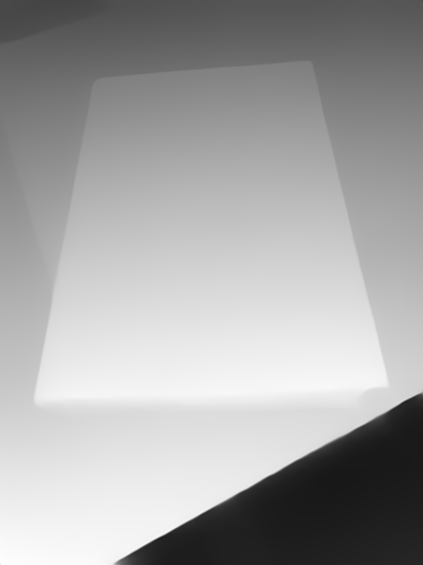

In [24]:
output = depth_estimator("images/book.webp")
print(output["predicted_depth"])
output["depth"]

In [25]:
"""
NOTE: cannot use depth_estimator on a full video.
FIX: convert video to individual frames, run estimator on each frame, and reconvert to video
"""

# output = depth_estimator("videos/IMG_2119.mov")
# This is a tensor with the values being the depth expressed in meters for each pixel
# output["depth"]

'\nNOTE: cannot use depth_estimator on a full video.\nFIX: convert video to individual frames, run estimator on each frame, and reconvert to video\n'

In [26]:
import numpy as np
depth_arr = np.asarray(output["depth"])

print(f"Depth Array Shape = {depth_arr.shape}")
print(depth_arr)
print(np.max(depth_arr))

Depth Array Shape = (565, 423)
[[ 71  71  72 ...  85  82  67]
 [ 71  71  72 ...  85  84  82]
 [ 71  71  72 ...  85  85  85]
 ...
 [254 253 253 ...  38  38  38]
 [251 253 254 ...  38  38  38]
 [225 251 255 ...  38  37  35]]
255


In [13]:
from transformers import pipeline
import numpy as np
import cv2

# Load the depth estimator model
checkpoint = "vinvino02/glpn-nyu"    
# checkpoint = "LiheYoung/depth-anything-base-hf"
depth_estimator = pipeline(task="depth-estimation", model=checkpoint)
test_path = "images\mason_statue.webp"

# Estimate depth from an image
output = depth_estimator(test_path)
depth_map = output["predicted_depth"][0]

# Convert depth_map to a numpy array
depth_map = np.array(depth_map, dtype=np.float32)

# Camera parameters for iPhone 15 Pro
f_x = f_y = 400 # 2245  # Estimated focal length in pixels
c_x = 0 # 2016        # Estimated x-coordinate of the optical center
c_y = 0 # 1512        # Estimated y-coordinate of the optical center

# Find the minimum non-zero depth value (closest object)
min_depth = np.min(depth_map[np.nonzero(depth_map)])

# Prepare to generate point cloud
height, width = depth_map.shape
point_cloud = []

for i in range(0, height, 5):
    for j in range(0, width, 5):
        Z = depth_map[i, j]
        
        # Check if the depth value is within a certain range around the minimum depth
        if Z > 0 and abs(Z - min_depth) < 2:
            X = (j - c_x) * Z / f_x
            Y = (i - c_y) * Z / f_y
            point_cloud.append([X, Z, -Y])   # Can change back to X, Y, Z for the coordinates

# Convert to a NumPy array
point_cloud = np.array(point_cloud)

# Save the point cloud
np.savetxt('point_cloud.xyz', point_cloud)


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\moham\AppData\Local\Temp\ipykernel_12156\1801735489.py:9: SyntaxWarning: invalid escape sequence '\m'
  test_path = "images\mason_statue.webp"
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


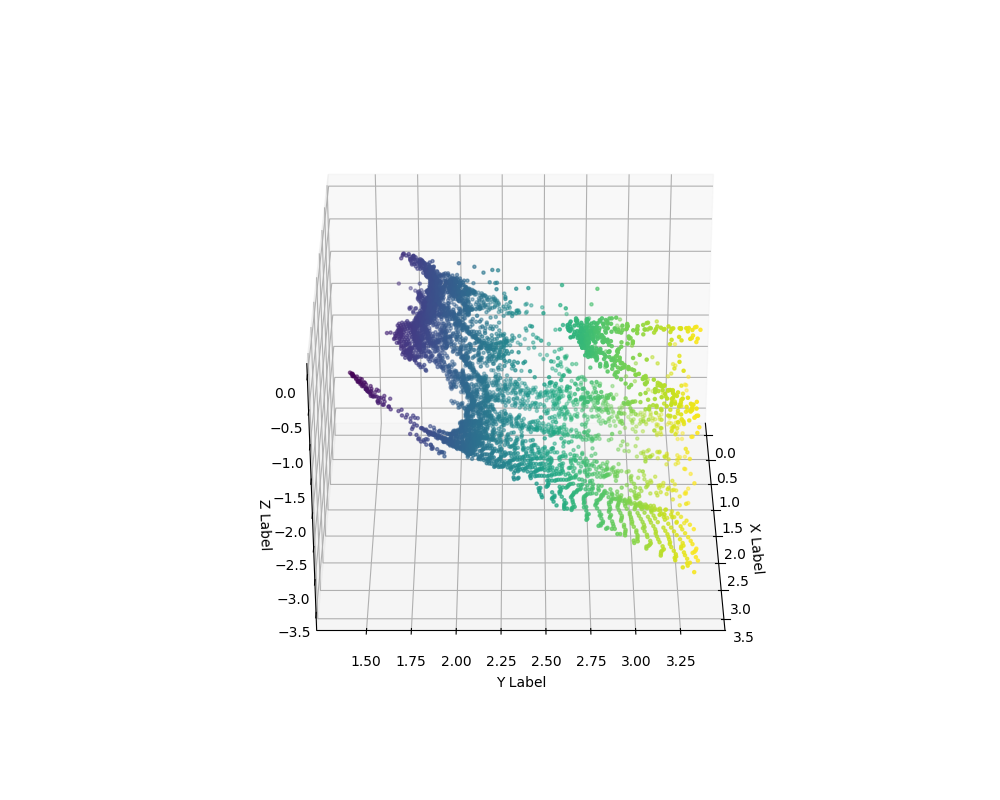

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

# Load point cloud data
point_cloud = np.loadtxt('point_cloud.xyz')

# Reshape the array to have two dimensions
point_cloud = point_cloud.reshape(-1, 3)

# Extracting individual components
x = point_cloud[:, 0]
y = point_cloud[:, 1]
z = point_cloud[:, 2]

# Function to update the plot
def update_plot(colormap='viridis', point_size=5, azimuth=0, elevation=30):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=y, cmap=colormap, marker='o', s=point_size) # Change c back to z when done looking
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(elev=elevation, azim=azimuth)
    plt.show()

colormap = 'viridis'
point_size = 5
azimuth = 0
elevation = 30

update_plot(colormap, point_size, azimuth, elevation)

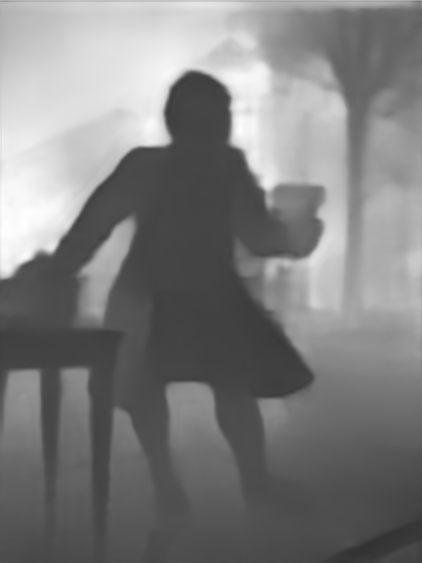

In [29]:
output["depth"]

In [30]:
print(np.asarray(output["predicted_depth"][0]).shape)
print(output["depth"].size)

(544, 416)
(422, 563)


In [31]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
img1 = cv.imread("C:/Users/matth/Pictures/my_room.webp", cv.IMREAD_GRAYSCALE)           # queryImage
img2 = cv.imread("C:/Users/matth/Pictures/my_room2.webp", cv.IMREAD_GRAYSCALE)          # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\features2d\src\sift.dispatch.cpp:512: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'cv::SIFT_Impl::detectAndCompute'


In [ ]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

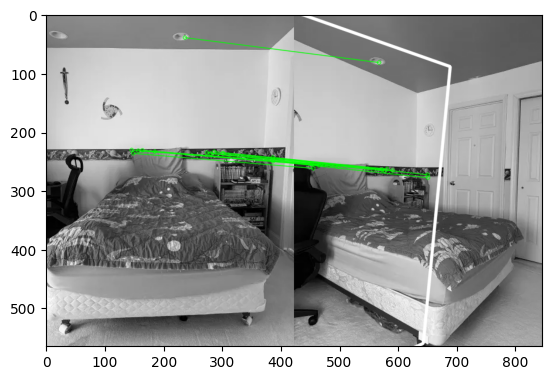

(<matplotlib.image.AxesImage at 0x1a525659490>, None)

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

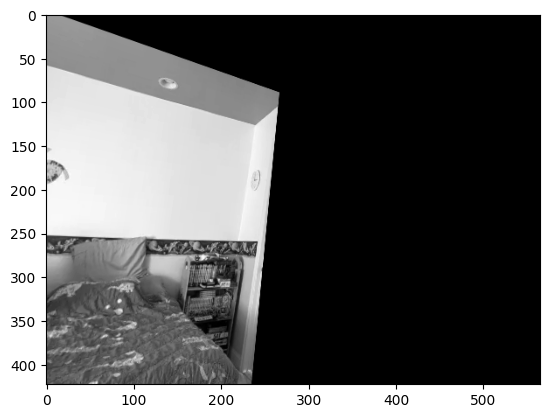

In [ ]:
warped_img = cv.warpPerspective(img1, M, img1.shape)
plt.figure()
plt.imshow(warped_img, cmap='gray')

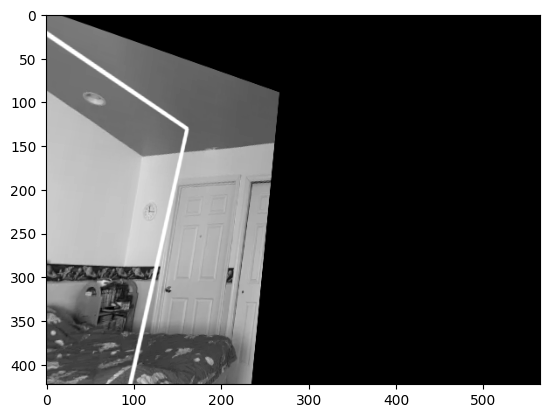

In [ ]:
sec_warped_img = cv.warpPerspective(img2, M, img1.shape)
plt.figure()
plt.imshow(sec_warped_img, cmap='gray')